# Homework solution

### Student: Megi Dervishi

In [1]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css").read()
    return HTML(styles)
css_styling()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from imutils import paths
import random
import time
import scipy.io as sio
import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.optimize import curve_fit

### Load Dataset

In [3]:
def load_data():
    #load from train -> from folder A have label 1 else have label 0
    # load from test -> same thing
    # shuffle
    print("Loading images...")
    df_train = pd.DataFrame()
    train_data, train_labels = [], []
    test_data, test_labels = [], []
    imgpath = sorted(list(paths.list_images("./data2")))
    random.seed(time.time())
    random.shuffle(imgpath)
    
    for ipath in imgpath:
        #print(ipath)
        image = cv2.imread(ipath,0)
        image = image.astype('float32') / 255
        tmp1, tmp2 = ipath.split(os.path.sep)[-3] , ipath.split(os.path.sep)[-2]
        #perhaps normalize the set X
        if tmp1 == "train": 
            train_data.append(image.flatten())
            if tmp2 == "A" and tmp1 == "train": 
                train_labels.append(1)
            else:
                train_labels.append(-1)
        else: 
            test_data.append(image.flatten())
            if tmp2 == "A": 
                test_labels.append(1)
            else: 
                test_labels.append(-1)
        #print(test_data)
        #input()
                
    train_data, test_data = np.array(train_data), np.array(test_data)
    train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    #df_train['Labels'] = [list(_) for _ in keras.utils.to_categorical(train_labels, 2)]
    print("Loading dataset done.")
    return train_data, test_data, train_labels, test_labels

In [4]:
train_data, test_data, train_labels, test_labels = load_data()

Loading images...
Loading dataset done.


### Define the Dataset

The images are $28$ by $28$ pixels that range from 0 to 255 but I have normalized them to range from 0 to 1. Hence we have that $\mathcal{X} \in [0,1]^{784}$ and $\mathcal{Y} \in \{1,-1\}$

In [5]:
print("Total training images: ", train_data.shape)
print("Total testing images: ", test_data.shape)
print("Number of 'A' from the training data: {} images".format(list(train_labels).count(1)))
print("Number of 'A' from the test data: {} images ".format(list(test_labels).count(1)))
print("Shape of the images: ", train_data[0].shape[0])

Total training images:  (900, 784)
Total testing images:  (750, 784)
Number of 'A' from the training data: 300 images
Number of 'A' from the test data: 250 images 
Shape of the images:  784


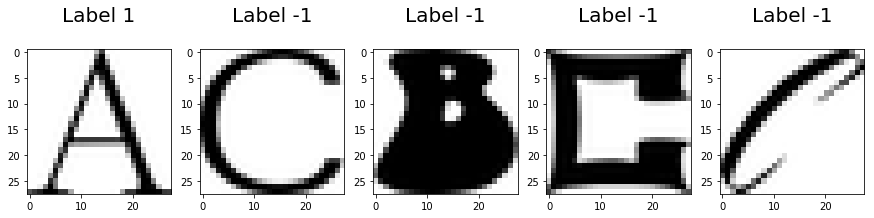

In [6]:
#examples from the dataset
plt.figure(figsize=(15,10))
for index, (image, label) in enumerate(zip(train_data[0:5], train_labels[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(image.reshape(28,28), cmap='binary')
 plt.title('Label %i\n' % label, fontsize = 20)